In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.core import *

In [1]:
import torch
from torch import Tensor
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DEVICE = torch.device('cpu')

In [3]:
import numpy as np
from torch import nn
from tomopt.volume import PassiveLayer, PanelDetectorLayer, DetectorPanel, Volume

In [30]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.9
    init_res = 1e4
    n_panels = 4
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[2.,2.],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[2.,2.],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [31]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([2., 2.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([2., 2.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([2., 2.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([2., 2.])
      )
    )
    (1): PassiveLayer located at z=tensor([0.8000])
    (2): PassiveLayer located at z=tensor([0.7000])
    (3): PassiveLayer located at z=tensor([0.6000])
    (4): PassiveLayer located at z=tensor([0.5000])
    (5): PassiveLayer located at z=tensor([0.4000])
    (6): PassiveLayer located at z=tensor([0.3000])
    (

In [32]:
volume.get_passives()[-1].z, volume.get_passives()[0].z

(tensor([0.3000]), tensor([0.8000]))

In [33]:
from functools import partial
from tomopt.optimisation import PanelVolumeWrapper, VoxelX0Loss, MuonResampler

In [34]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=7, cost_coef=None))  # Loss is precision + budget_coef*cost_coef, balance coef as required or leave as None to automatically balance on first batch

In [35]:
from tomopt.core import X0
from tomopt.optimisation.data.passives import AbsPassiveGenerator
from typing import *

In [87]:
class LadleFurnacePassiveGenerator(AbsPassiveGenerator):
    def __init__(
        self,
        volume: Volume,
        x0_furnace: float = X0["iron"],
        fill_materials: List[str] = ["aluminium"],
        slag_materials: List[str] = ["silicon", "carbon", "beryllium"],
    ) -> None:
        self.x0_furnace,self.fill_materials,self.slag_materials = x0_furnace,fill_materials,slag_materials
        super().__init__(volume=volume, materials=self.fill_materials+self.slag_materials)
        self.slag_x0s = Tensor([X0[m] for m in self.slag_materials], device=self.volume.device)
        self.fill_x0s = Tensor([X0[m] for m in self.fill_materials], device=self.volume.device)
        
        self.xy_shp = (self.lw / self.size).astype(int).tolist()
        self.fill_z_range = ((self.z_range[0]) + self.size, self.z_range[1])

    def _generate(self) -> Tuple[Callable[..., Tensor], Tensor]:
        mat_z = self.size+self.fill_z_range[0]+((self.fill_z_range[1]-(self.fill_z_range[0]+self.size))*torch.rand(1, device=self.volume.device))
        slag_z = mat_z+((self.z_range[1]-mat_z)*torch.rand(1, device=self.volume.device))

        def generator(*, z: float, lw: Tensor, size: float) -> Tensor:
            if z <= self.fill_z_range[0]:
                x0 = self.x0_furnace * torch.ones(self.xy_shp)
            elif z > self.fill_z_range[0] and z <= mat_z:
                x0 = self.fill_x0s[torch.randint(high=len(self.fill_x0s), size=(self.xy_shp[0] * self.xy_shp[1],), device=self.fill_x0s.device)].reshape(
                    self.xy_shp
                )
            elif z > mat_z and z <= slag_z:
                x0 = self.slag_x0s[torch.randint(high=len(self.slag_x0s), size=(self.xy_shp[0] * self.xy_shp[1],), device=self.slag_x0s.device)].reshape(
                    self.xy_shp
                )
            elif z > slag_z:
                x0 = X0["air"] * torch.ones(self.xy_shp)
            x0[0,:]=self.x0_furnace
            x0[-1,:]=self.x0_furnace
            x0[:,0]=self.x0_furnace  
            x0[:,-1]=self.x0_furnace  
            return x0

        return generator, mat_z

In [88]:
from tomopt.optimisation import PassiveYielder

In [89]:
pgen = LadleFurnacePassiveGenerator(volume)

In [90]:
pgen.fill_z_range

(0.3000000178813934, 0.800000011920929)

In [92]:
pgen.lw / pgen.size

array([10., 10.], dtype=float32)

In [93]:
pgen.size*(pgen.lw /pgen.size)

array([1., 1.], dtype=float32)

In [94]:
volume.passive_size

0.1

In [95]:
pgen.xy_shp

[10, 10]

In [96]:
f,t = pgen.get_data();t

tensor([0.7711])

In [97]:
volume.load_rad_length(f, t)

In [98]:
from tomopt.plotting import plot_pred_true_x0

In [99]:
true = volume.get_rad_cube()

In [100]:
from tomopt.utils import x0targs_to_classtargs

In [101]:
x02id = {X0[m]:i for i,m in enumerate(X0)}

In [102]:
true

tensor([[[1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02,
          1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02],
         [1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02,
          1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02],
         [1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02,
          1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02],
         [1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02,
          1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02],
         [1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02,
          1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02],
         [1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02,
          1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02],
         [1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02,
          1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02, 1.7570e-02],
         [1.7

In [103]:
class_true = x0targs_to_classtargs(true, x02id)

Absolute fill height tensor([0.7711])
Fill height in voxels tensor([5.])
Zero-ordered target layer ID: tensor([4.])


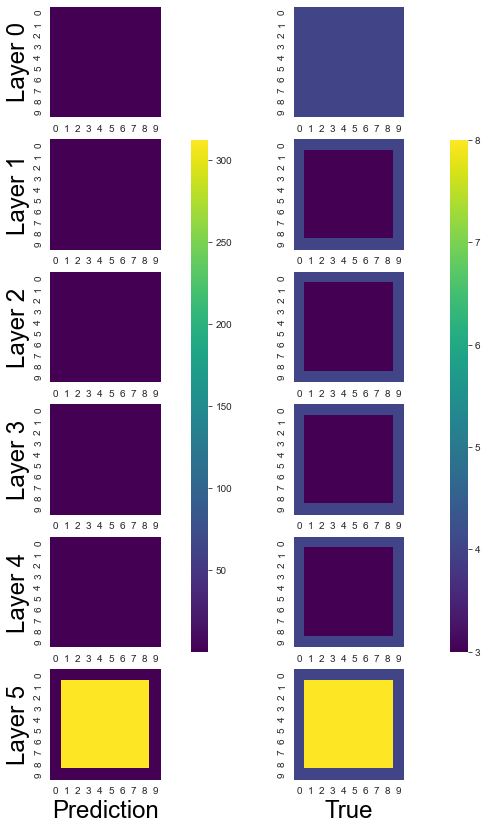

In [104]:
print("Absolute fill height", t)
print("Fill height in voxels", np.floor((t-volume.get_passive_z_range()[0])/volume.passive_size))
print("Zero-ordered target layer ID:", np.floor((t-volume.get_passive_z_range()[0])/volume.passive_size)-1)
plot_pred_true_x0(true, class_true)

In [82]:
volume.get_passives()[0].rad_length.shape

torch.Size([10, 10])

In [83]:
passives = PassiveYielder(pgen, n_passives=1)

In [84]:
preds = wrapper.predict(passives,
                        n_mu_per_volume=10000,
                        mu_bs=100,
                        cbs=[MuonResampler()])

/Users/giles/cernbox/mode_muon_tomography/tomopt/inference/scattering.py:329: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


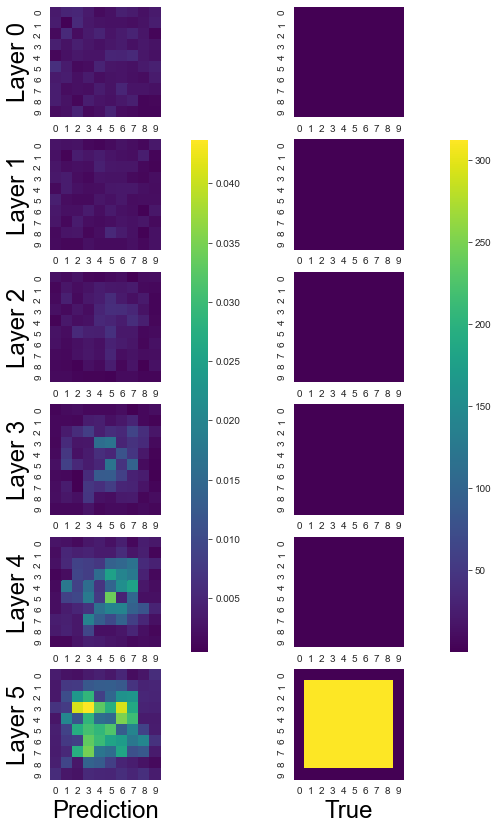

In [85]:
plot_pred_true_x0(*preds[0])

Zero-ordered target layer ID: tensor([1.])


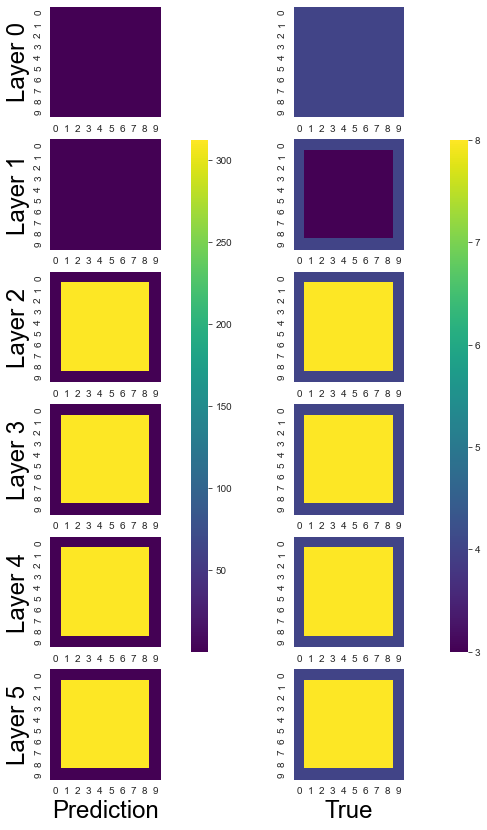

Zero-ordered target layer ID: tensor([4.])


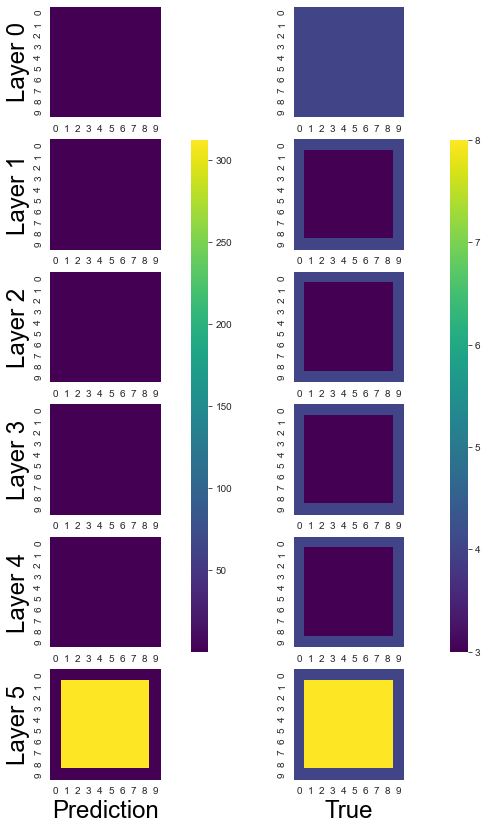

Zero-ordered target layer ID: tensor([3.])


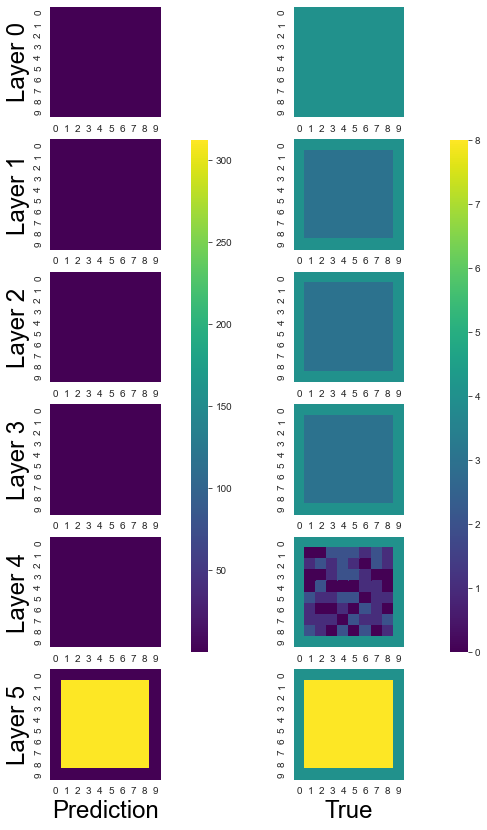

Zero-ordered target layer ID: tensor([2.])


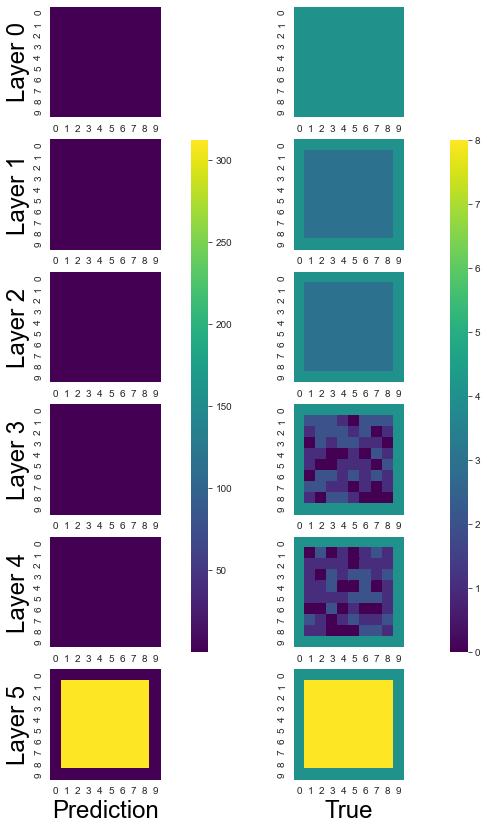

Zero-ordered target layer ID: tensor([3.])


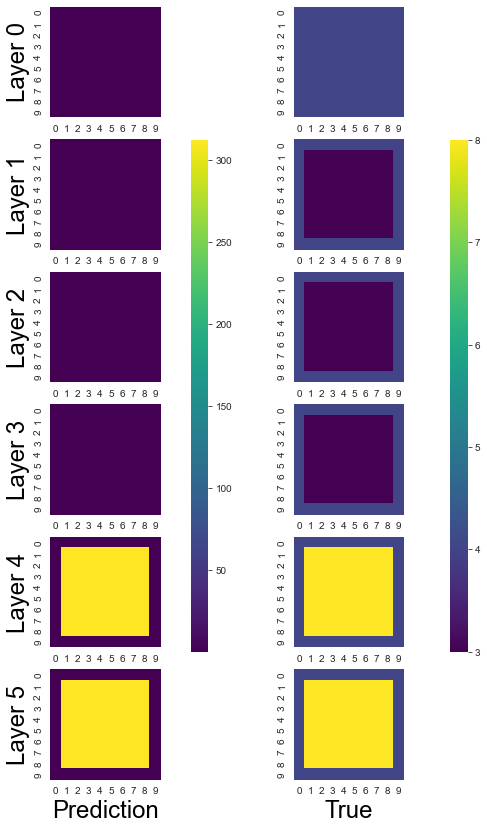

Zero-ordered target layer ID: tensor([4.])


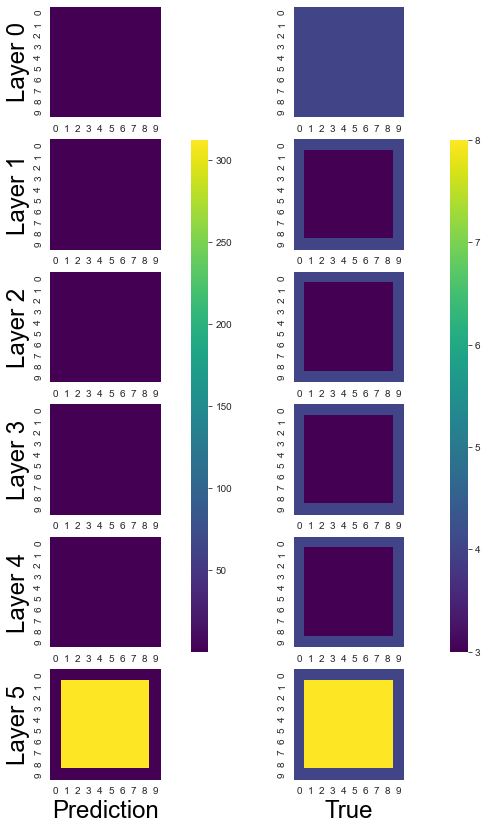

Zero-ordered target layer ID: tensor([3.])


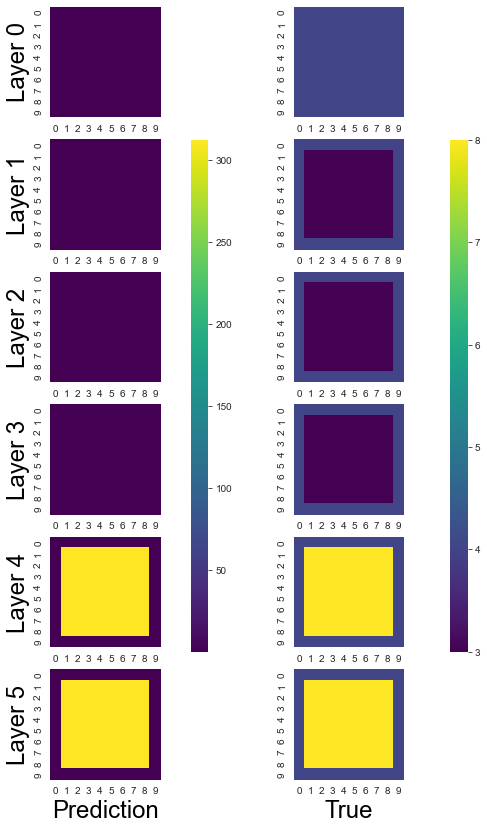

Zero-ordered target layer ID: tensor([2.])


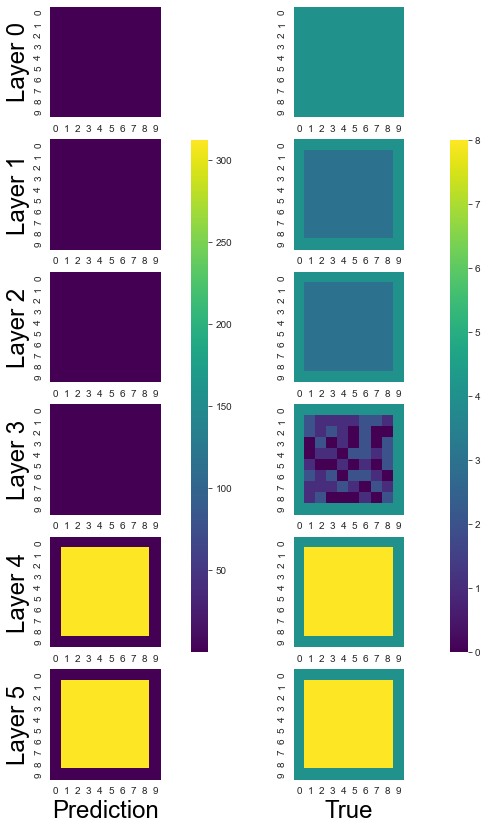

Zero-ordered target layer ID: tensor([4.])


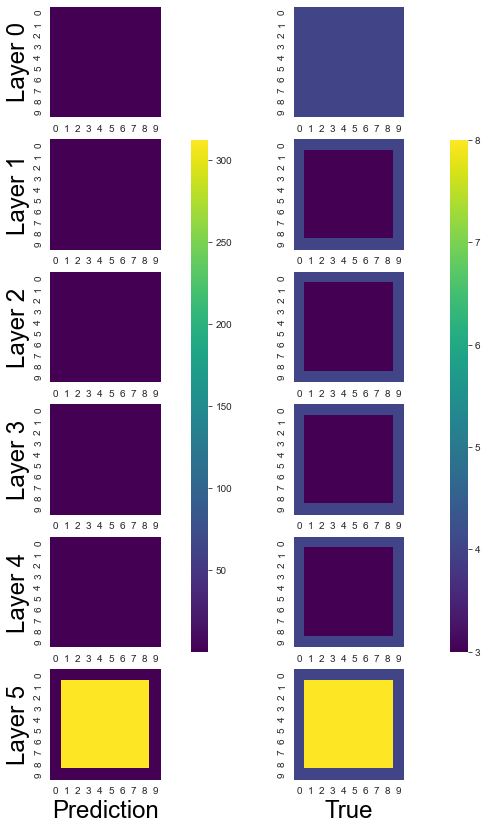

Zero-ordered target layer ID: tensor([4.])


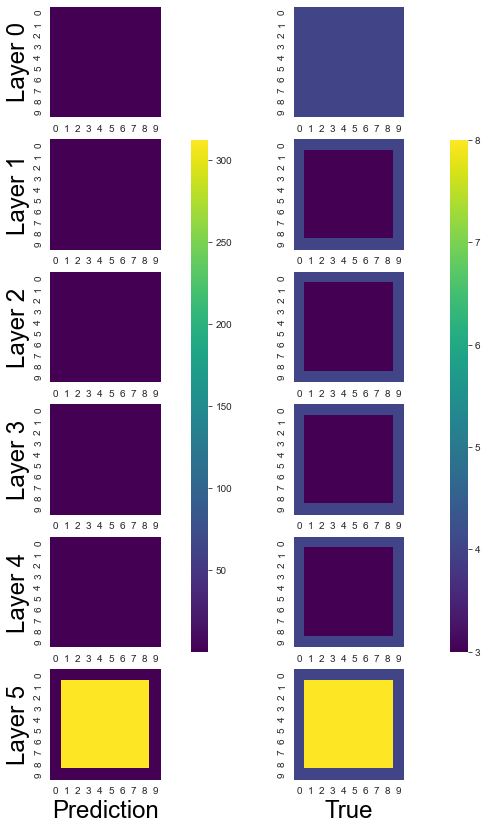

In [105]:
passives = PassiveYielder(pgen, n_passives=10)
for f,t in passives:
    volume.load_rad_length(f)
    true = volume.get_rad_cube()
    class_true = x0targs_to_classtargs(true, x02id)
    print("Zero-ordered target layer ID:", np.floor((t-volume.get_passive_z_range()[0]-volume.passive_size)/volume.passive_size))
    plot_pred_true_x0(true, class_true)